<a href="https://colab.research.google.com/github/uca-spider/customer_segmentation/blob/main/customer_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load dataset
df = pd.read_excel('/content/drive/MyDrive/colab/Online Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
print("Jumlah baris awal dataset:", len(df))
print("Jumlah CustomerID unik:", df['CustomerID'].nunique())
print("Kolom dataset:", df.columns)
df.head()

Jumlah baris awal dataset: 541909
Jumlah CustomerID unik: 4372
Kolom dataset: Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
# Hitung missing values
print("Jumlah missing values per kolom:")
print(df.isnull().sum())

Jumlah missing values per kolom:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [5]:
print("Jumlah CustomerID NaN:", df['CustomerID'].isna().sum())

Jumlah CustomerID NaN: 135080


In [6]:
df1 = df.dropna(subset=['CustomerID'])
print("Setelah drop CustomerID NaN:", len(df1))

Setelah drop CustomerID NaN: 406829


In [7]:
print("Jumlah transaksi Quantity <= 0:", (df1['Quantity'] <= 0).sum())

Jumlah transaksi Quantity <= 0: 8905


In [8]:
df2 = df1[df1['Quantity'] > 0]
print("Setelah filter Quantity > 0:", len(df2))

Setelah filter Quantity > 0: 397924


In [9]:
print("Jumlah transaksi UnitPrice <= 0:", (df2['UnitPrice'] <= 0).sum())

Jumlah transaksi UnitPrice <= 0: 40


In [10]:
df3 = df2[df2['UnitPrice'] > 0]
print("Setelah filter UnitPrice > 0:", len(df3))

Setelah filter UnitPrice > 0: 397884


In [11]:
print("Jumlah Invoice Cancel (prefix C):", df3['InvoiceNo'].astype(str).str.startswith('C').sum())

Jumlah Invoice Cancel (prefix C): 0


In [12]:
df4 = df3[~df3['InvoiceNo'].astype(str).str.startswith('C')]
print("Setelah drop Invoice Cancel:", len(df4))

Setelah drop Invoice Cancel: 397884


In [13]:
df4['TotalPrice'] = df4['Quantity'] * df4['UnitPrice']
print("Jumlah baris final setelah cleaning:", len(df4))

Jumlah baris final setelah cleaning: 397884


In [14]:
snapshot_date = df4['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df4.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

rfm.rename(columns={'InvoiceDate': 'Recency',
                    'InvoiceNo': 'Frequency',
                    'TotalPrice': 'Monetary'}, inplace=True)
print("Jumlah CustomerID unik setelah RFM:", len(rfm))
print(rfm.head())

Jumlah CustomerID unik setelah RFM: 4338
   CustomerID  Recency  Frequency  Monetary
0     12346.0      326          1  77183.60
1     12347.0        2          7   4310.00
2     12348.0       75          4   1797.24
3     12349.0       19          1   1757.55
4     12350.0      310          1    334.40


In [15]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4338 entries, 0 to 4337
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  4338 non-null   float64
 1   Recency     4338 non-null   int64  
 2   Frequency   4338 non-null   int64  
 3   Monetary    4338 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 135.7 KB


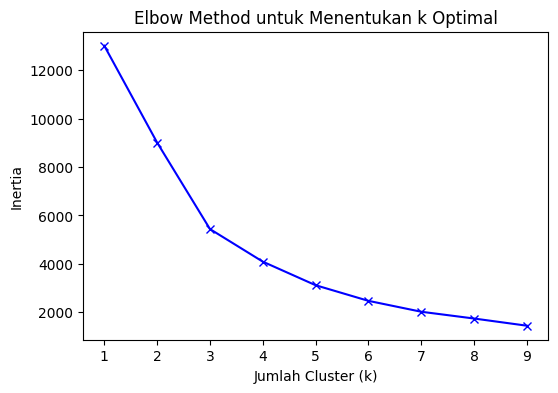

         CustomerID  Recency  Frequency  Monetary
Cluster                                          
0           15355.0    247.1        1.6     631.4
1           15282.8     41.5        4.7    1855.9
2           15208.6      6.0       66.4   85904.4


In [18]:
# Pastikan CustomerID tidak ikut dalam scaling
rfm_features = rfm[['Recency', 'Frequency', 'Monetary']]

# Normalisasi
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)

# Elbow Method untuk cari k optimal
inertia = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method untuk Menentukan k Optimal')
plt.show()

# Cek hasil
print(rfm.groupby('Cluster').mean().round(1))

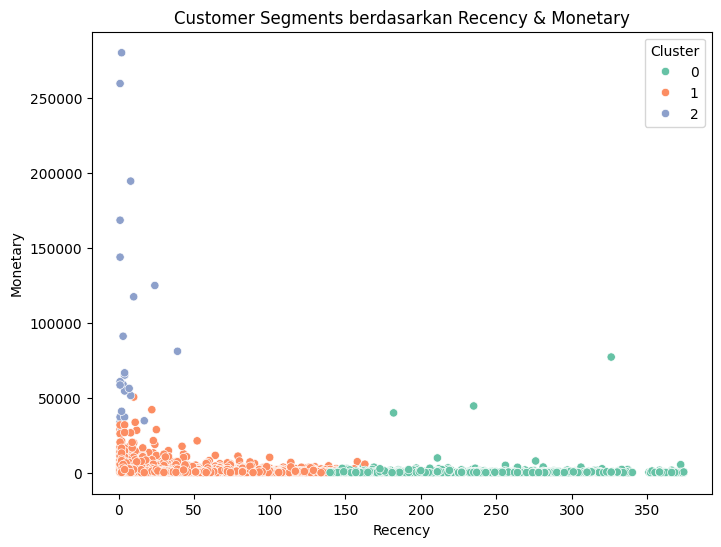

In [17]:
# Contoh gunakan k=3 (sesuaikan dengan elbow curve)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette='Set2')
plt.title('Customer Segments berdasarkan Recency & Monetary')
plt.show()

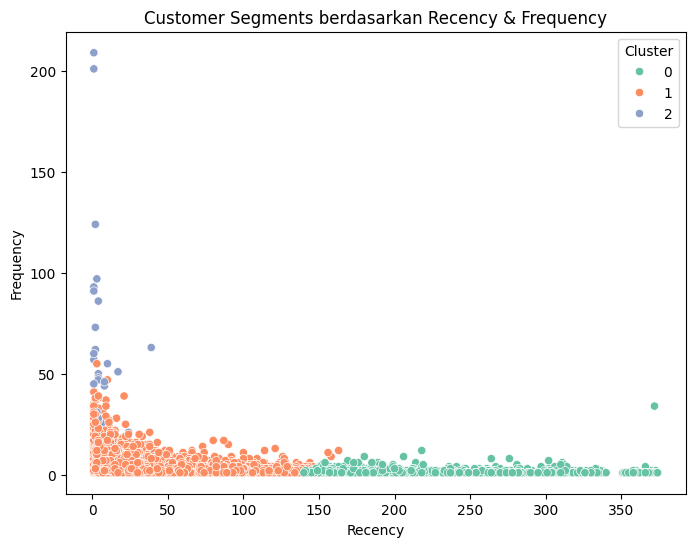

In [22]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=rfm, x='Recency', y='Frequency', hue='Cluster', palette='Set2')
plt.title('Customer Segments berdasarkan Recency & Frequency')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.show()

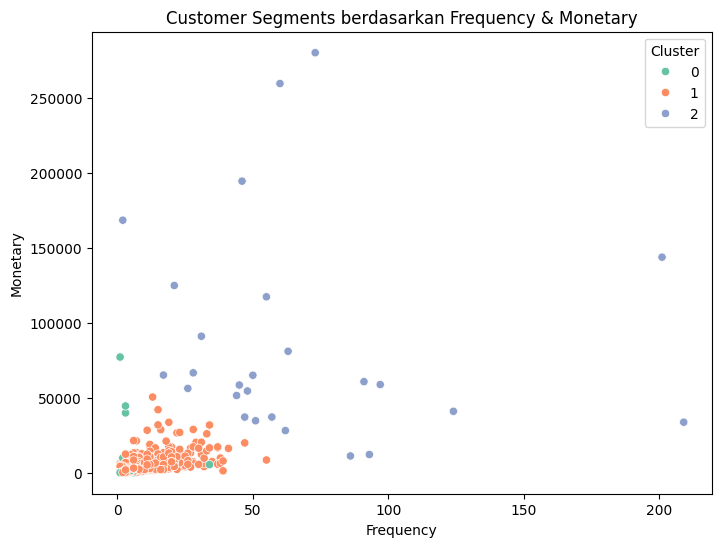

In [23]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=rfm, x='Frequency', y='Monetary', hue='Cluster', palette='Set2')
plt.title('Customer Segments berdasarkan Frequency & Monetary')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.show()

In [19]:
import plotly.express as px

fig = px.scatter_3d(
    rfm,
    x='Recency',
    y='Frequency',
    z='Monetary',
    color='Cluster',
    title="3D Customer Segmentation (RFM Clusters)",
    color_continuous_scale='Viridis'
)
fig.update_traces(marker=dict(size=3))
fig.show()

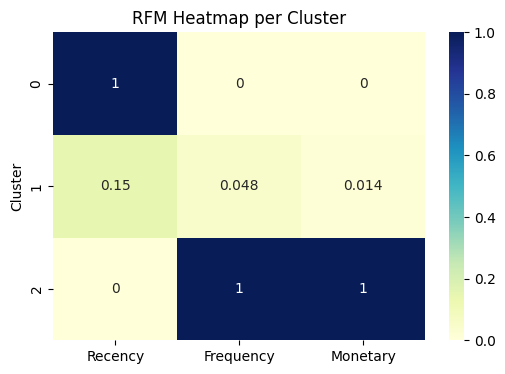

In [20]:
# Ambil hanya kolom RFM
rfm_mean = rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().round(1)

# Normalisasi nilai untuk heatmap
rfm_norm = (rfm_mean - rfm_mean.min()) / (rfm_mean.max() - rfm_mean.min())

plt.figure(figsize=(6,4))
sns.heatmap(rfm_norm, annot=True, cmap="YlGnBu")
plt.title('RFM Heatmap per Cluster')
plt.show()

In [21]:
# Sort cluster berdasarkan Monetary untuk estimasi ranking
cluster_labels = rfm_mean.sort_values(by='Monetary', ascending=False).index
for i, cl in enumerate(cluster_labels):
    print(f"Cluster {cl}: Rank {i+1}")

Cluster 2: Rank 1
Cluster 1: Rank 2
Cluster 0: Rank 3
